__Что было сделано:__

- Получено с сайта hh 337 резюме (фильтр Data Scientist по России);

- Наименование вакансий приведено к нормальному виду (было 219 стало 7);

- Почищен текст описания вакансий;

- Найдены биграммы с разбивкой по вакансиям.   




# Парсинг

In [ ]:
!pip install requests

In [ ]:
import pandas as pd

import requests

In [ ]:
import json
import time
import os

In [ ]:
def getPage(page = 0):
    """
    Создаем метод для получения страницы со списком вакансий.
    Аргументы:
        page - Индекс страницы, начинается с 0. Значение по умолчанию 0, т.е. первая страница
    """

    # Справочник для параметров GET-запроса
    params = {
        'text': 'NAME:Data Scientist', # Текст фильтра. В имени должно быть слово "Data Scientist"
        'area': 113, # Поиск ощуществляется по вакансиям России
        'page': page, # Индекс страницы поиска на HH
        'per_page': 100 # Кол-во вакансий на 1 странице
    }


    req = requests.get('https://api.hh.ru/vacancies', params) # Посылаем запрос к API
    data = req.content.decode() # Декодируем его ответ, чтобы Кириллица отображалась корректно
    req.close()
    return data

In [ ]:
# Считываем первые 2000 вакансий
for page in range(0, 20):

    # Преобразуем текст ответа запроса в справочник Python
    jsObj = json.loads(getPage(page))

    # Сохраняем файлы в папку {путь до текущего документа со скриптом}/content/sample_data/hh_DS_Россия_
    # Определяем количество файлов в папке для сохранения документа с ответом запроса
    # Полученное значение используем для формирования имени документа
    nextFileName = '/content/sample_data/hh_DS_Россия_2/{}.json'.format(len(os.listdir('/content/sample_data/hh_DS_Россия_2')))

    # Создаем новый документ, записываем в него ответ запроса, после закрываем
    f = open(nextFileName, mode='w', encoding='utf8')
    f.write(json.dumps(jsObj, ensure_ascii=False))
    f.close()

    # Проверка на последнюю страницу, если вакансий меньше 2000
    if (jsObj['pages'] - page) <= 1:
        break

    # Необязательная задержка, но чтобы не нагружать сервисы hh, оставим. 5 сек мы может подождать
    time.sleep(0.25)

print('Страницы поиска собраны')

Страницы поиска собраны


In [ ]:
# Получаем перечень ранее созданных файлов со списком вакансий и проходимся по нему в цикле
for fl in os.listdir('/content/sample_data/hh_DS_Россия_2'):

    # Открываем файл, читаем его содержимое, закрываем файл
    f = open('/content/sample_data/hh_DS_Россия_2/{}'.format(fl), encoding='utf8')
    jsonText = f.read()
    f.close()

    # Преобразуем полученный текст в объект справочника
    jsonObj = json.loads(jsonText)

    # Получаем и проходимся по непосредственно списку вакансий
    for v in jsonObj['items']:

        # Обращаемся к API и получаем детальную информацию по конкретной вакансии
        req = requests.get(v['url'])
        data = req.content.decode()
        req.close()

        # Создаем файл в формате json с идентификатором вакансии в качестве названия
        # Записываем в него ответ запроса и закрываем файл
        fileName = '/content/sample_data/hh_вакансии_2/{}.json'.format(v['id'])
        f = open(fileName, mode='w', encoding='utf8')
        f.write(data)
        f.close()

        time.sleep(0.25)

In [ ]:
# Библиотека для работы с СУБД
from sqlalchemy import engine as sql

# Модуль для работы с отображением вывода Jupyter
from IPython import display


In [ ]:
# Создаем списки для столбцов таблицы vacancies
IDs = [] # Список идентификаторов вакансий
names = [] # Список наименований вакансий
descriptions = [] # Список описаний вакансий

In [ ]:
# Создаем списки для столбцов таблицы skills
skills_vac = [] # Список идентификаторов вакансий
skills_name = [] # Список названий навыков


In [ ]:
# В выводе будем отображать прогресс
# Для этого узнаем общее количество файлов, которые надо обработать
# Счетчик обработанных файлов установим в ноль
cnt_docs = len(os.listdir('/content/sample_data/hh_вакансии_2'))
i = 0

In [ ]:
# Проходимся по всем файлам в папке vacancies
for fl in os.listdir('/content/sample_data/hh_вакансии_2'):

    # Открываем, читаем и закрываем файл
    f = open('/content/sample_data/hh_вакансии_2/{}'.format(fl), encoding='utf8')
    jsonText = f.read()
    f.close()

    # Текст файла переводим в справочник
    jsonObj = json.loads(jsonText)

    # Заполняем списки для таблиц
    IDs.append(jsonObj['id'])
    names.append(jsonObj['name'])
    descriptions.append(jsonObj['description'])

    # Т.к. навыки хранятся в виде массива, то проходимся по нему циклом
    for skl in jsonObj['key_skills']:
        skills_vac.append(jsonObj['id'])
        skills_name.append(skl['name'])

    # Увеличиваем счетчик обработанных файлов на 1, очищаем вывод ячейки и выводим прогресс
    i += 1
    display.clear_output(wait=True)
    display.display('Готово {} из {}'.format(i, cnt_docs))

'Готово 337 из 337'

In [ ]:
df_vacancies = pd.DataFrame({'id': IDs, 'name': names, 'description': descriptions})

In [ ]:
df_skills = pd.DataFrame({'vacancy': skills_vac, 'skill': skills_name})

In [ ]:
df_vacancies

,id,name,description
0,67411146,"Ведущий Data Scientist, Ранжирование поиска",<p>Наша команда занимается разработкой сервисо...
1,85939099,Chief Data Scientist,<p>В Samokat.tech мы делаем ИТ-решения для рит...
2,86544326,Data Scientist,<p>МТС Банк – цифровой банк экосистемы МТС. Мы...
3,86492289,Data scientist (computer vision),<p>АО «Гознак» – один из крупнейших в мире про...
4,87465889,Senior Data Scientist,"<p><strong>РСХБ-ИНТЕХ</strong>— молодая, драйв..."
...,...,...,...
332,80805489,Senior Data Scientist,"<p>Работа в Agile команде по методологии SAFE,..."
333,86388990,Data scientist/ML,<p><strong>Budu – </strong>это уникальный medt...
334,86178242,Data scientist (Персональная скидка),<p>В нашу команду профессионалов ищем специали...
335,85562079,Data scientist / Специалист по нейросетям,<p>В связи с ростом числа задач с применением ...


In [ ]:
df_skills

,vacancy,skill
0,67411146,Python
1,67411146,data science
2,67411146,Разработка поисковых технологий
3,67411146,IT
4,85939099,Управление командой
...,...,...
1523,86388990,машинное обучение
1524,86388990,PyTorch
1525,85051758,Python
1526,85051758,SQL


In [ ]:
df_skills.to_csv (r'df_skills.csv', index = None, header=True)

In [ ]:
df_vacancies.to_csv (r'df_vacancies.csv', index = None, header=True)

# Чистим наименование вакансий

In [ ]:
import pandas as pd

In [ ]:
df_vacancies = pd.read_csv('df_vacancies.csv')

In [ ]:
df_skills = pd.read_csv('df_skills.csv')

In [ ]:
df_vacancies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337 entries, 0 to 336
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           337 non-null    int64 
 1   name         337 non-null    object
 2   description  337 non-null    object
dtypes: int64(1), object(2)
memory usage: 8.0+ KB


In [ ]:
df_vacancies.name.value_counts()

Data Scientist                                                  33
Data scientist                                                  17
Senior Data Scientist                                           13
Data Scientist в команду ранжирования                            6
Data Engineer                                                    6
                                                                ..
Data engineer / data analyst (Дирекция цифрового развития)       1
Data Scientist (моделист в банк направление кредитные риски)     1
Владелец продукта (продукты Data Science)                        1
Data engineer/Data scientist                                     1
Data scientist (Персональная скидка)                             1
Name: name, Length: 219, dtype: int64

In [ ]:
sample = df_vacancies[df_vacancies.name == 'Junior Data Scientist']
print(len(sample))

3


In [ ]:
sample.head()

,id,name,description
49,86787125,Junior Data Scientist,<p><strong>Обязанности:</strong></p> <ul> <li>...
77,86195321,Junior Data Scientist,<p>Бюро кредитных историй <strong>Cкоринг Бюро...
114,82174408,Junior Data Scientist,<p> </p> <p><strong>Обязанности:</strong></p> ...


In [ ]:
import re
regex = re.compile('[a-яz]+')

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""

In [ ]:
# токенизация
df_vacancies['name_1'] =df_vacancies['name'].str.lower().apply(words_only)

In [ ]:
print('ГРЯЗНЫЕ ДАННЫЕ:')
print(df_vacancies.name.value_counts())
print('-------------------------------')
print('ПОСЛЕ ОЧИСТКИ:')
print(df_vacancies.name_1.value_counts())

ГРЯЗНЫЕ ДАННЫЕ:
Data Scientist                                                  33
Data scientist                                                  17
Senior Data Scientist                                           13
Data Scientist в команду ранжирования                            6
Data Engineer                                                    6
                                                                ..
Data engineer / data analyst (Дирекция цифрового развития)       1
Data Scientist (моделист в банк направление кредитные риски)     1
Владелец продукта (продукты Data Science)                        1
Data engineer/Data scientist                                     1
Data scientist (Персональная скидка)                             1
Name: name, Length: 219, dtype: int64
-------------------------------
ПОСЛЕ ОЧИСТКИ:
data scientist                                                51
senior data scientist                                         14
data scientist middle           

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
from nltk.tokenize import word_tokenize

In [ ]:
from collections import Counter
corpus = [token for tweet in df_vacancies.name_1 for token in word_tokenize(tweet) if token not in punctuation]

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
print(stopwords.words('russian'))
print(stopwords.words('english'))

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [ ]:
noise = stopwords.words('russian')+stopwords.words('english')+list(punctuation)

In [ ]:
def remove_stopwords(text, mystopwords = noise):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

In [ ]:
# удаляем стоп-слова и пунктуацию
df_vacancies['name_1'] = df_vacancies['name_1'].apply(remove_stopwords)

In [ ]:
!pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 39.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13705 sha256=f52040fa0758de2160ae49c12c8ff38e1f1602c64df44a5bcec1f19b2676aa53
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [ ]:
import pymorphy2
m = pymorphy2.MorphAnalyzer()

In [ ]:
def lemmatize(text, morph=m):
    try:
        return ' '.join([morph.parse(word)[0].normal_form for word in text.split()])
    except:
        return " "


In [ ]:
# лемматизируем
df_vacancies['name_1'] = df_vacancies['name_1'].apply(lemmatize)

In [ ]:
df_vacancies.head()

,id,name,description,name_1
0,67411146,"Ведущий Data Scientist, Ранжирование поиска",<p>Наша команда занимается разработкой сервисо...,ведущий data scientist ранжирование поиск
1,85939099,Chief Data Scientist,<p>В Samokat.tech мы делаем ИТ-решения для рит...,chief data scientist
2,86544326,Data Scientist,<p>МТС Банк – цифровой банк экосистемы МТС. Мы...,data scientist
3,86492289,Data scientist (computer vision),<p>АО «Гознак» – один из крупнейших в мире про...,data scientist computer vision
4,87465889,Senior Data Scientist,"<p><strong>РСХБ-ИНТЕХ</strong>— молодая, драйв...",senior data scientist


In [ ]:
#составляем частотный словарь
corpus = [token for tweet in df_vacancies.name_1 for token in word_tokenize(tweet) if token not in punctuation]
freq_dict = Counter(corpus).most_common()
freq_dict_ = list(zip(*freq_dict))[0]
freq_dict_

In [ ]:
# дополняем список стоп-слов
noise = ['команда',
 'модель',
 'данные',
 'риск',
 'team',
 'специалист',
 'кредитный',
 'ранжирование',
 'ai',
 'разработчик',
 'стажёр',
 'разработка',
 'ведущий',
 'скоринг',
 'управление',
 'клиент',
 'развитие',
 'анализ',
 'рекомендация',
 'инженер',
 'cv',
 'корпоративный',
 'центр',
 'направление',
 'моделирование',
 'система',
 'поиск',
 'валидатор',
 'блок',
 'процесс',
 'удалённый',
 'mlops',
 'рекомендательный',
 'продукт',
 'бизнес',
 'банковский',
 'торговый',
 'книга',
 'быстрый',
 'доставка',
 'operations',
 'речь',
 'валидация',
 'исследование',
 'сопровождение',
 'использование',
 'работа',
 'департамент',
 'киб',
 'антифрод',
 'python',
 'программист',
 'маркетплейс',
 'промый',
 'прогноз',
 'r',
 'rec',
 'system',
 'дирекция',
 'цифровой',
 'big',
 'cvm',
 'геоаналитика',
 'quantitative',
 'розничный',
 'математик',
 'вконтакте',
 'компьютерный',
 'зрение',
 'developer',
 'coreml',
 'платформа',
 'эксперимент',
 'группа',
 'recsys',
 'рыночный',
 'sberdata',
 'реклама',
 'ценообразование',
 'перспективный',
 'алгоритм',
 'оптимизация',
 'econometrist',
 'eta',
 'синтез',
 'manager',
 'сервисный',
 'экосистема',
 'руководитель',
 'клиентский',
 'опыт',
 'управлять',
 'cпециалиста',
 'gigachat',
 'больший',
 'страта',
 'смб',
 'remote',
 'extensive',
 'experience',
 'экономист',
 'tensorflow',
 'портфельный',
 'скоринговый',
 'консультант',
 'ицб',
 'отношение',
 'детекция',
 'фотошоп',
 'документ',
 'антибот',
 'домен',
 'intern',
 'минимальный',
 'чек',
 'почта',
 'crm',
 'нестандартный',
 'моделист',
 'банк',
 'владелец',
 'маркетинговый',
 'sberai',
 'распознавание',
 'pricing',
 'antifraud',
 'cyprus',
 'автор',
 'модуль',
 'дискретный',
 'мy',
 'tracker',
 'финансы',
 'b',
 'c',
 'sber',
 'smartsearch',
 'supply',
 'rnd',
 'ranking',
 'recommendations',
 'базовый',
 'collection',
 'инновационный',
 'ner',
 'azure',
 'personalization',
 'генеративный',
 'дизайн',
 'ads',
 'platform',
 'авиа',
 'главный',
 'исследователь',
 'каско',
 'преподаватель',
 'удалой',
 'нно',
 'контент',
 'проект',
 'customer',
 'value',
 'management',
 'mltech',
 'bigdata',
 'alm',
 'макроэкономист',
 'автоматизация',
 'sbercare',
 'бот',
 'researcher',
 'plp',
 'прогнозирование',
 'г',
 'южный',
 'сахалинск',
 'помощник',
 'брокерский',
 'llm',
 'sbernba',
 'math',
 'expert',
 'стаж',
 'р',
 'товарный',
 'старший',
 'эффективность',
 'цена',
 'trade',
 'математический',
 'bi',
 '«',
 'персонализация',
 'коммуникация',
 'потребность',
 'клиента',
 '»',
 'фундаментальный',
 'lab',
 'казначейство',
 'временной',
 'ряд',
 'персональный',
 'скидка',
  '«персонализация',
  'клиента»',
  'computer',
'vision',
'ml',
'машинный',
'обучение',
'nlp',
'machine',
'learning',
'нейросеть',
'аналитик',
'analyst'
         ]

In [ ]:
def remove_stopwords(text, mystopwords = noise):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

In [ ]:
# удаляем дополнительные стоп-слова
df_vacancies['name_1'] = df_vacancies['name_1'].apply(remove_stopwords)

In [ ]:
print('ГРЯЗНЫЕ ДАННЫЕ:')
print(df_vacancies.name.value_counts())
print('-------------------------------')
print('ПОСЛЕ ОЧИСТКИ:')
print(df_vacancies.name_1.value_counts())
print('-------------------------------')
print('Уменьшили количество вхождений по наименованию вакансий на', df_vacancies.name.nunique()-df_vacancies.name_1.nunique(), '(было', df_vacancies.name.nunique(), 'стало', df_vacancies.name_1.nunique(), ')')

ГРЯЗНЫЕ ДАННЫЕ:
Data Scientist                                                  33
Data scientist                                                  17
Senior Data Scientist                                           13
Data Scientist в команду ранжирования                            6
Data Engineer                                                    6
                                                                ..
Data engineer / data analyst (Дирекция цифрового развития)       1
Data Scientist (моделист в банк направление кредитные риски)     1
Владелец продукта (продукты Data Science)                        1
Data engineer/Data scientist                                     1
Data scientist (Персональная скидка)                             1
Name: name, Length: 219, dtype: int64
-------------------------------
ПОСЛЕ ОЧИСТКИ:
data scientist                                           159
senior data scientist                                     43
lead data scientist                     

In [ ]:
# немного чистим вручную
df_vacancies_1 = df_vacancies.replace({'name_1' : {'lead data science' : 'lead data scientist','data engineer' : 'engineer data scientist', 'data scientist engineer' : 'engineer data scientist','data scientist middle' : 'middle data scientist', 'data scientist middle senior' : 'middle senior data scientist', 'data scientist senior' : 'senior data scientist', 'data science' : 'data scientist', 'data' : 'data scientist'}})

In [ ]:
print(df_vacancies_1.name_1.value_counts())

data scientist                                           169
senior data scientist                                     45
middle data scientist                                     28
lead data scientist                                       23
engineer data scientist                                   19
middle senior data scientist                              18
junior data scientist                                      7
senior data scientist engineer                             2
data scientist data                                        2
senior data scientist senior engineer senior engineer      2
senior data engineer                                       1
junior data engineer                                       1
teamlead data scientist                                    1
начинающий data scientist                                  1
senior data scientst                                       1
data scientict                                             1
engineer data engineer  

In [ ]:
df_vacancies_new=df_vacancies_1.loc[df_vacancies_1.name_1.isin(['data scientist', 'senior data scientist','middle data scientist','lead data scientist', 'engineer data scientist', 'middle senior data scientist', 'junior data scientist'])]

In [ ]:
df_vacancies_new

,id,name,description,name_1
0,67411146,"Ведущий Data Scientist, Ранжирование поиска",<p>Наша команда занимается разработкой сервисо...,data scientist
2,86544326,Data Scientist,<p>МТС Банк – цифровой банк экосистемы МТС. Мы...,data scientist
3,86492289,Data scientist (computer vision),<p>АО «Гознак» – один из крупнейших в мире про...,data scientist
4,87465889,Senior Data Scientist,"<p><strong>РСХБ-ИНТЕХ</strong>— молодая, драйв...",senior data scientist
5,86877928,Стажер Data Scientist,<p>Мы разрабатываем и внедряем ML решения для ...,data scientist
...,...,...,...,...
332,80805489,Senior Data Scientist,"<p>Работа в Agile команде по методологии SAFE,...",senior data scientist
333,86388990,Data scientist/ML,<p><strong>Budu – </strong>это уникальный medt...,data scientist
334,86178242,Data scientist (Персональная скидка),<p>В нашу команду профессионалов ищем специали...,data scientist
335,85562079,Data scientist / Специалист по нейросетям,<p>В связи с ростом числа задач с применением ...,data scientist


In [ ]:
df_vacancies_new.name_1.unique()

array(['data scientist', 'senior data scientist',
       'engineer data scientist', 'lead data scientist',
       'middle data scientist', 'middle senior data scientist',
       'junior data scientist'], dtype=object)

In [ ]:
df_vacancies_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 309 entries, 0 to 336
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           309 non-null    int64 
 1   name         309 non-null    object
 2   description  309 non-null    object
 3   name_1       309 non-null    object
dtypes: int64(1), object(3)
memory usage: 12.1+ KB


In [ ]:
print('В результате чистки наименования вакансий потеряли', round(((df_vacancies.shape[0]-df_vacancies_new.shape[0])/df_vacancies.shape[0])*100), '% данных, это в пределах рекоменуемых 10%')

В результате чистки наименования вакансий потеряли 8 % данных, это в пределах рекоменуемых 10%


In [ ]:
df_vacancies_new=df_vacancies_new.drop(['id','name'], axis=1) # удалили не нужные далее столбцы

In [ ]:
df_vacancies_new.to_csv (r'df_vacancies_new.csv', index = None, header=True)

# Работа с описанием вакансий

## Чистим описание вакансий

In [ ]:
import pandas as pd

In [ ]:
df_vacancies_new = pd.read_csv('df_vacancies_new.csv')

In [ ]:
import re
regex = re.compile('[a-яz]+')

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""

In [ ]:
# токенизация
df_vacancies_new['description'] = df_vacancies_new['description'].str.lower().apply(words_only)

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
from nltk.tokenize import word_tokenize

In [ ]:
from collections import Counter
corpus = [token for tweet in df_vacancies_new.description for token in word_tokenize(tweet) if token not in punctuation]

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
print(stopwords.words('russian'))
print(stopwords.words('english'))

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [ ]:
noise = stopwords.words('russian')+stopwords.words('english')+list(punctuation)

In [ ]:
def remove_stopwords(text, mystopwords = noise):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

In [ ]:
# удаляем стоп-слова и пунктуацию
df_vacancies_new['description'] = df_vacancies_new['description'].apply(remove_stopwords)

In [ ]:
!pip install pymorphy2

In [ ]:
import pymorphy2
m = pymorphy2.MorphAnalyzer()

In [ ]:
def lemmatize(text, morph=m):
    try:
        return ' '.join([morph.parse(word)[0].normal_form for word in text.split()])
    except:
        return " "


In [ ]:
# лемматизируем
df_vacancies_new['description'] = df_vacancies_new['description'].apply(lemmatize)

In [ ]:
df_vacancies_new

,description,name_1
0,p наш команда заниматься разработка сервис пои...,data scientist
1,p мтс банк цифровой банк экосистема мтс задава...,data scientist
2,p ао «гознак» крупный мир производитель защити...,data scientist
3,p strong рсхб интех strong молодой драйвовый к...,senior data scientist
4,p разрабатывать внедрять ml решение интеграция...,data scientist
...,...,...
304,p работа agile команда методология safe которы...,senior data scientist
305,p strong budu strong это уникальный medtech се...,data scientist
306,p наш команда профессионал искать специалист п...,data scientist
307,p связь рост число задача применение искусстве...,data scientist


In [ ]:
#составляем частотный словарь
corpus = [token for tweet in df_vacancies_new.description for token in word_tokenize(tweet) if token not in punctuation]
freq_dict = Counter(corpus).most_common()
freq_dict_ = list(zip(*freq_dict))[0]
freq_dict_

('li',
 'p',
 'strong',
 'ul',
 'работа',
 'модель',
 'опыт',
 'данные',
 'задача',
 'обучение',
 'команда',
 'знание',
 'разработка',
 'ml',
 'наш',
 'решение',
 'анализ',
 'компания',
 'python',
 'бизнес',
 'машинный',
 'br',
 'data',
 'алгоритм',
 'продукт',
 'который',
 'возможность',
 'проект',
 'работать',
 'система',
 'область',
 'корпоративный',
 'sql',
 'год',
 'метод',
 'офис',
 'процесс',
 'em',
 'хороший',
 'новый',
 'понимание',
 'клиент',
 'требование',
 'умение',
 'участие',
 'результат',
 'развитие',
 'построение',
 'математический',
 'условие',
 'библиотека',
 'банк',
 'использование',
 'статистика',
 'дмс',
 'ds',
 'искать',
 'плюс',
 'технология',
 'сотрудник',
 'сервис',
 'предлагать',
 'создание',
 'управление',
 'навык',
 'высокий',
 'другой',
 'внедрение',
 'день',
 'оценка',
 'scientist',
 'поиск',
 'моделирование',
 'уровень',
 'качество',
 'разрабатывать',
 'технический',
 'заниматься',
 'так',
 'основа',
 'обработка',
 '·',
 'программа',
 'quot',
 'nlp',
 'вн

In [ ]:
# дополняем список стоп-слов
noise = ['li', 'p', 'ul', 'наш', 'br', 'год', 'em', 'ds', 'так', '·', 'quot', 'nlp', 'ai', 'b', '«', 'также',  'использовать',  '»', 'применение',  'свой', 'м', 'предстоять',  'это', 'быть', 'иметь', 'каждый',   'основный', 'дать', 'др', 'тк',  'полный', 'далее', 'docker', 'мы', 'весь', 'число', 'уметь', 'самый', 'х', 'участвовать', 'ит', 'включая', 'взаимодействие', 'жизнь', 'ожидать', 'необходимый', 'amp', 'п', 'r', 'c', 'стать', 'такой', 'наличие', 'являться', 'митапа', 'желательно', 'дополнительный', 'нужно', 'любой', 'ты', 'например', 'разный', 'llm', 'основной', 'твой', 'менее', 'мат', 'мочь', 'полностью', 'вместе', 'срок', 'hive', 'начало', 'очень', 'ol','сделать', 'текущий', 'ваш', 'продвинуть', 'быстро','смочь', 'etc', 'годовой', 'возможный', 'прод', 'поэтому', 'крутой', 'важный', 'важно',  'связанный', 'пр', 'город', 'сам', 'etl', 'bi', 'обсуждаться', 'выполнение', 'отсутствие', 'несколько', 'почему', 'ия', 'ведение', 'согласно', 'среди', 'этот', 'e', 'граф', 'kafka', 'итог', 'знакомство', 'развитой', 'внутри', 'хотеть', 'кутузовский', 'находить', 'вс', 'совместно', 'тот', 'событие', 'бд', 'нужный', 'помочь', 'совместный', 'cd', 'какой', 'млн', 'оценивать', 'необходимость', 'настоящий',  'рада', 'постоянный', 'просто', 'среда', 'нный', 'принимать', 'ревить', 'около', 'проверять', 'б', 'страна', 'соответствие', 'последний', 'частичный', 'самостоятельно', 'санкт', 'петербург', 'промый', 'давать', 'выше', 'пользоваться', 'следующий', 'мфть', 'регулярно', 'de', 'регион', 'тд', 'аба', 'ещ', 'партн', 'либо', 'множество', 'многое', 'go', 'ров', 'уютный', 'вести', 'отношение', 'постоянно', 'выгодный','напрямую', 'наиболее', 'пвр', 'надёжный', 'многий', 'sas', 'hdfs', 'нно', 'жд', 'esg',  'созд', 'небольшой', 'ускорить', '...']

In [ ]:
def remove_stopwords(text, mystopwords = noise):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

In [ ]:
# удаляем дополнительные стоп-слова
df_vacancies_new['description'] = df_vacancies_new['description'].apply(remove_stopwords)

## Биграммы для вакансии Data Scientist

In [ ]:
from nltk.util import ngrams

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns

In [ ]:
# Подготовка текста для анализа частотности
list_text = []
for string in df_vacancies_new[df_vacancies_new['name_1']=='data scientist']['description']:
    list_text.append(string)
list_text

str_text = str(list_text)
tokens = word_tokenize(str_text)
txt_tokens = [word.lower() for word in tokens if word.isalpha()]

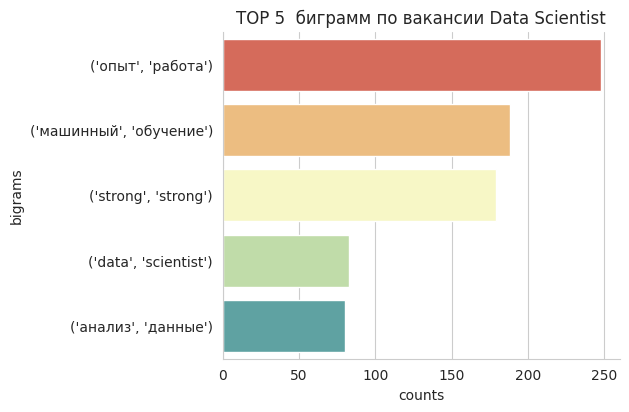

In [ ]:
# Создаем датасет самых частотных биграмм
bigrams_series = (pd.Series(nltk.ngrams(txt_tokens, 2)).value_counts())[:5]
bigrams_top = pd.DataFrame(bigrams_series.sort_values(ascending=False))
bigrams_top = bigrams_top.reset_index().rename(columns={'index': 'bigrams', 0:'counts'})

# Визуализация биграмм
sns.catplot(x = 'counts' , y='bigrams', kind="bar", palette="Spectral", data=bigrams_top, height=4, aspect=8/5)
plt.title('TOP 5  биграмм по вакансии Data Scientist');


## Биграммы для вакансии Senior Data Scientist

In [ ]:
df_vacancies_new.name_1.unique()

array(['data scientist', 'senior data scientist',
       'engineer data scientist', 'lead data scientist',
       'middle data scientist', 'middle senior data scientist',
       'junior data scientist'], dtype=object)

In [ ]:
# Подготовка текста для анализа частотности
list_text = []
for string in df_vacancies_new[df_vacancies_new['name_1']=='senior data scientist']['description']:
    list_text.append(string)
list_text

str_text = str(list_text)
tokens = word_tokenize(str_text)
txt_tokens = [word.lower() for word in tokens if word.isalpha()]

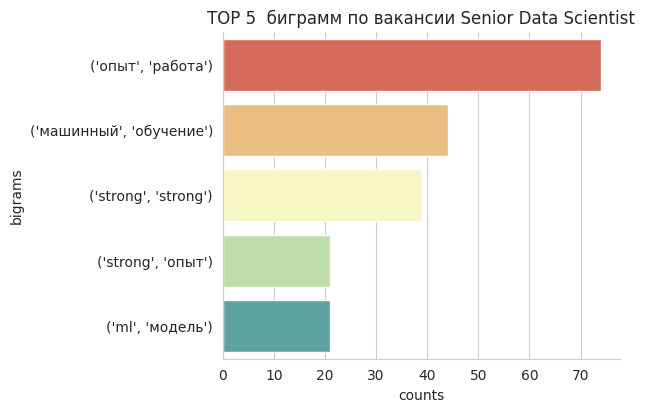

In [ ]:
# Создаем датасет самых частотных биграмм
bigrams_series = (pd.Series(nltk.ngrams(txt_tokens, 2)).value_counts())[:5]
bigrams_top_1 = pd.DataFrame(bigrams_series.sort_values(ascending=False))
bigrams_top_1 = bigrams_top_1.reset_index().rename(columns={'index': 'bigrams', 0:'counts'})

# Визуализация биграмм
sns.catplot(x = 'counts' , y='bigrams', kind="bar", palette="Spectral", data=bigrams_top_1, height=4, aspect=8/5)
plt.title('TOP 5  биграмм по вакансии Senior Data Scientist');


## Биграммы для вакансии Engineer Data Scientist

In [ ]:
# Подготовка текста для анализа частотности
list_text = []
for string in df_vacancies_new[df_vacancies_new['name_1']=='engineer data scientist']['description']:
    list_text.append(string)
list_text

str_text = str(list_text)
tokens = word_tokenize(str_text)
txt_tokens = [word.lower() for word in tokens if word.isalpha()]

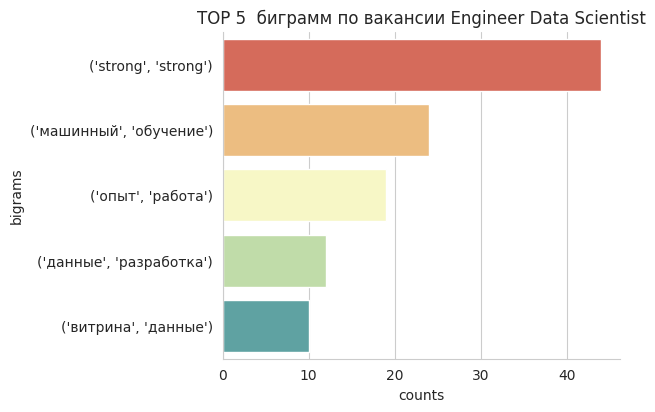

In [ ]:
# Создаем датасет самых частотных биграмм
bigrams_series = (pd.Series(nltk.ngrams(txt_tokens, 2)).value_counts())[:5]
bigrams_top_2 = pd.DataFrame(bigrams_series.sort_values(ascending=False))
bigrams_top_2 = bigrams_top_2.reset_index().rename(columns={'index': 'bigrams', 0:'counts'})

# Визуализация биграмм
sns.catplot(x = 'counts' , y='bigrams', kind="bar", palette="Spectral", data=bigrams_top_2, height=4, aspect=8/5)
plt.title('TOP 5  биграмм по вакансии Engineer Data Scientist');


## Биграммы для вакансии Lead Data Scientist

In [ ]:
df_vacancies_new.name_1.unique()

array(['data scientist', 'senior data scientist',
       'engineer data scientist', 'lead data scientist',
       'middle data scientist', 'middle senior data scientist',
       'junior data scientist'], dtype=object)

In [ ]:
# Подготовка текста для анализа частотности
list_text = []
for string in df_vacancies_new[df_vacancies_new['name_1']=='lead data scientist']['description']:
    list_text.append(string)
list_text

str_text = str(list_text)
tokens = word_tokenize(str_text)
txt_tokens = [word.lower() for word in tokens if word.isalpha()]

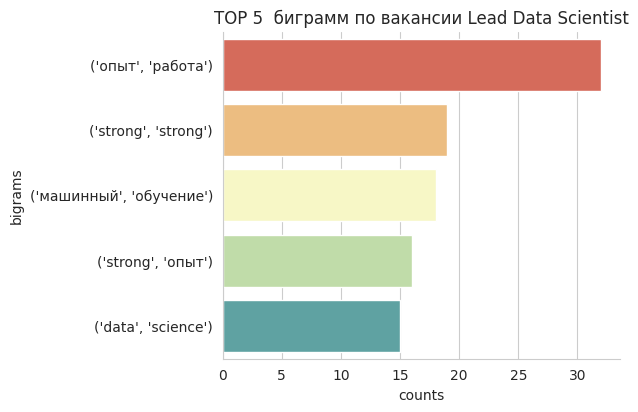

In [ ]:
# Создаем датасет самых частотных биграмм
bigrams_series = (pd.Series(nltk.ngrams(txt_tokens, 2)).value_counts())[:5]
bigrams_top_3 = pd.DataFrame(bigrams_series.sort_values(ascending=False))
bigrams_top_3 = bigrams_top_3.reset_index().rename(columns={'index': 'bigrams', 0:'counts'})

# Визуализация биграмм
sns.catplot(x = 'counts' , y='bigrams', kind="bar", palette="Spectral", data=bigrams_top_3, height=4, aspect=8/5)
plt.title('TOP 5  биграмм по вакансии Lead Data Scientist');


## Биграммы для вакансии Middle Data Scientist

In [ ]:
# Подготовка текста для анализа частотности
list_text = []
for string in df_vacancies_new[df_vacancies_new['name_1']=='middle data scientist']['description']:
    list_text.append(string)
list_text

str_text = str(list_text)
tokens = word_tokenize(str_text)
txt_tokens = [word.lower() for word in tokens if word.isalpha()]

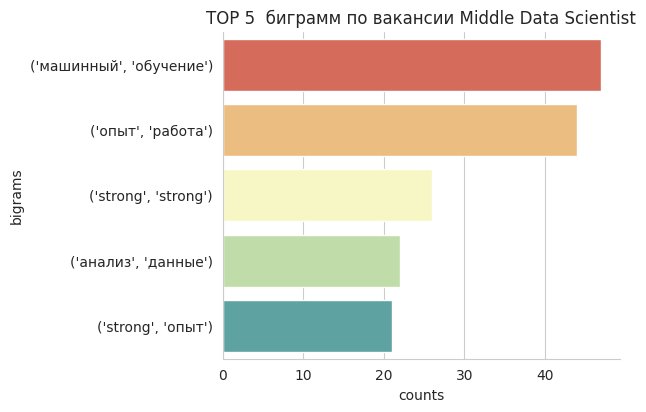

In [ ]:
# Создаем датасет самых частотных биграмм
bigrams_series = (pd.Series(nltk.ngrams(txt_tokens, 2)).value_counts())[:5]
bigrams_top_4 = pd.DataFrame(bigrams_series.sort_values(ascending=False))
bigrams_top_4 = bigrams_top_4.reset_index().rename(columns={'index': 'bigrams', 0:'counts'})

# Визуализация биграмм
sns.catplot(x = 'counts' , y='bigrams', kind="bar", palette="Spectral", data=bigrams_top_4, height=4, aspect=8/5)
plt.title('TOP 5  биграмм по вакансии Middle Data Scientist');


## Биграммы для вакансии Middle Senior Data Scientist

In [ ]:
# Подготовка текста для анализа частотности
list_text = []
for string in df_vacancies_new[df_vacancies_new['name_1']=='middle senior data scientist']['description']:
    list_text.append(string)
list_text

str_text = str(list_text)
tokens = word_tokenize(str_text)
txt_tokens = [word.lower() for word in tokens if word.isalpha()]

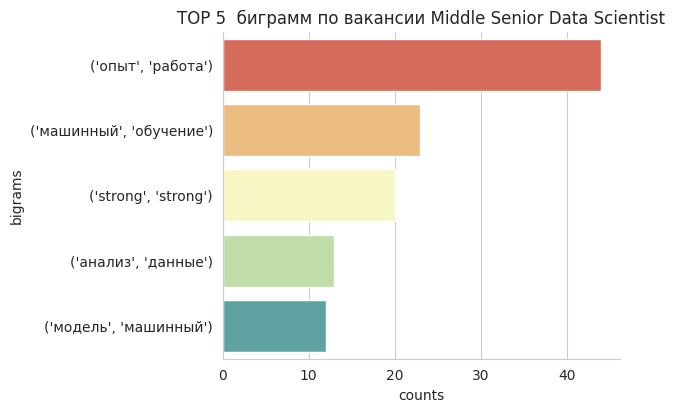

In [ ]:
# Создаем датасет самых частотных биграмм
bigrams_series = (pd.Series(nltk.ngrams(txt_tokens, 2)).value_counts())[:5]
bigrams_top_5 = pd.DataFrame(bigrams_series.sort_values(ascending=False))
bigrams_top_5 = bigrams_top_5.reset_index().rename(columns={'index': 'bigrams', 0:'counts'})

# Визуализация биграмм
sns.catplot(x = 'counts' , y='bigrams', kind="bar", palette="Spectral", data=bigrams_top_5, height=4, aspect=8/5)
plt.title('TOP 5  биграмм по вакансии Middle Senior Data Scientist');


## Биграммы для вакансии Junior Data Scientist

In [ ]:
# Подготовка текста для анализа частотности
list_text = []
for string in df_vacancies_new[df_vacancies_new['name_1']=='junior data scientist']['description']:
    list_text.append(string)
list_text

str_text = str(list_text)
tokens = word_tokenize(str_text)
txt_tokens = [word.lower() for word in tokens if word.isalpha()]

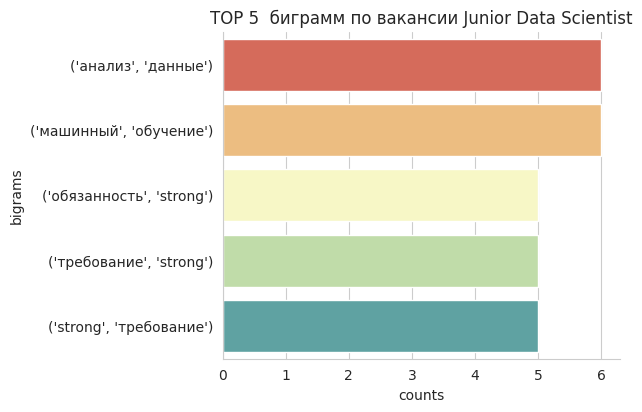

In [ ]:
# Создаем датасет самых частотных биграмм
bigrams_series = (pd.Series(nltk.ngrams(txt_tokens, 2)).value_counts())[:5]
bigrams_top_6 = pd.DataFrame(bigrams_series.sort_values(ascending=False))
bigrams_top_6 = bigrams_top_6.reset_index().rename(columns={'index': 'bigrams', 0:'counts'})

# Визуализация биграмм
sns.catplot(x = 'counts' , y='bigrams', kind="bar", palette="Spectral", data=bigrams_top_6, height=4, aspect=8/5)
plt.title('TOP 5  биграмм по вакансии Junior Data Scientist');


## Сводка по биграммам

In [ ]:
df_vacancies_new.name_1.unique()

array(['data scientist', 'senior data scientist',
       'engineer data scientist', 'lead data scientist',
       'middle data scientist', 'middle senior data scientist',
       'junior data scientist'], dtype=object)

In [ ]:
bigrams_top_all = pd.concat([bigrams_top, bigrams_top_1,bigrams_top_2, bigrams_top_3, bigrams_top_4, bigrams_top_5, bigrams_top_6], axis=1,
                            keys=['data scientist', 'senior data scientist',
       'engineer data scientist', 'lead data scientist',
       'middle data scientist', 'middle senior data scientist',
       'junior data scientist'])
bigrams_top_all.loc[:4].style.set_properties(**{'background-color': '#000066',
                           'color': 'lawngreen',
                           'border-color': 'white'})